In [1]:
import h2o
import numpy as np
import pandas as pd
import re
import joblib


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix


from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators import H2OXGBoostEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.grid.grid_search import H2OGridSearch


import matplotlib.pyplot as plt
import seaborn as sns


from xgboost import XGBClassifier


import shap

%matplotlib inline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# MODEL TRAINING



After finishing the data preprocessing and imputation, I will train the model. I will use 3 algorithms to compare the result, and use the top 2 as baseline models. The algorithms are gradient boosting, deep learning, and XGBoost. For the first 2 algorithms, I will use the H2O library. For the XGBoost algorithm, I will use the XGBoost library since it is not supported in the current version of H2O (I'm using windows). In the next notebook, I will perform feature engineering to add features to the dataset, hopefully making the model better. If the model is not better, I will use the best of the baseline models to create a prediction pipeline.

In [5]:
df_use = pd.read_csv(r'D:\LoanLens\data\final_data.csv')

In [6]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 24+36-3646, mixed mode, sharing)
  Starting server from D:\user\envs\LoanLens\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\psing\AppData\Local\Temp\tmpgf7y3f28
  JVM stdout: C:\Users\psing\AppData\Local\Temp\tmpgf7y3f28\h2o_psing_started_from_python.out
  JVM stderr: C:\Users\psing\AppData\Local\Temp\tmpgf7y3f28\h2o_psing_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.2
H2O_cluster_version_age:,"1 year, 9 months and 18 days"
H2O_cluster_name:,H2O_from_python_psing_3rm2x5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.965 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [7]:
hf = h2o.H2OFrame(df_use)


predictors = list(df_use.columns[1:])
response = "loan_status"

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [8]:
train_temp, test = hf.split_frame(ratios = [.8], seed = 42)
train, val = train_temp.split_frame(ratios = [.8], seed = 42)

In [9]:
def train_gbm_h2o(predictors, response, train, test, val, learn_rate, max_depth, ntrees, sample_rate, col_sample_rate):
    #hyperparameters to tune
    gbm_params1 = {'learn_rate': learn_rate,
                   'max_depth': max_depth,
                   'ntrees': ntrees,
                   'sample_rate': sample_rate,
                   'col_sample_rate': col_sample_rate}

    #initializing grid search
    gbm_grid1 = H2OGridSearch(
        model=H2OGradientBoostingEstimator,
        grid_id='gbm_grid1',
        hyper_params=gbm_params1
    )

    #train the model
    gbm_grid1.train(
        x=predictors,
        y=response,
        training_frame=train,
        validation_frame=val,  # Include your validation frame here
        seed=42
    )

    gbm_gridperf1 = gbm_grid1.get_grid(sort_by='aucpr', decreasing=True)

    #get the best model
    best_gbm1 = gbm_gridperf1.models[0]

    #evaluate the model against the test data
    gbm_perf = best_gbm1.model_performance(test)

    return best_gbm1, gbm_perf, gbm_gridperf1

In [10]:
learn_rate = [0.01, 0.05, 0.1]
max_depth = [5, 7, 9]
ntrees = [300, 500, 700]
sample_rate = [0.5, 0.8, 1.0]
col_sample_rate = [0.25, 0.5, 1.0]
best_gbm1, gbm_perf, gbm_gridperf1 = train_gbm_h2o(predictors, response, train, test, val, learn_rate, max_depth, ntrees, sample_rate, col_sample_rate)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


In [11]:
gbm_gridperf1

,col_sample_rate,learn_rate,max_depth,ntrees,sample_rate,model_ids,aucpr
,0.5,0.01,9.0,700.0,0.8,gbm_grid1_model_155,0.4902100
,0.5,0.05,5.0,500.0,0.8,gbm_grid1_model_113,0.4901196
,0.5,0.05,5.0,700.0,0.8,gbm_grid1_model_140,0.4901196
,0.5,0.01,7.0,700.0,1.0,gbm_grid1_model_227,0.4895625
,0.25,0.05,7.0,300.0,1.0,gbm_grid1_model_175,0.4894498
,0.25,0.01,9.0,700.0,1.0,gbm_grid1_model_235,0.4892906
,0.5,0.05,7.0,300.0,0.8,gbm_grid1_model_95,0.4891393
,0.5,0.05,5.0,300.0,0.8,gbm_grid1_model_86,0.4890637
,0.5,0.01,7.0,700.0,0.8,gbm_grid1_model_146,0.4889649
,1.0,0.01,7.0,700.0,0.5,gbm_grid1_model_66,0.4887975


In [12]:
print(gbm_perf)

ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.18212307731508567
RMSE: 0.4267588046134323
LogLoss: 0.5434612233032778
Mean Per-Class Error: 0.3667252570984753
AUC: 0.6918409189624262
AUCPR: 0.4801200497390328
Gini: 0.38368183792485233

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2581153875435356
              loan_given    loan_refused    Error    Rate
------------  ------------  --------------  -------  ----------------
loan_given    7305          5474            0.4284   (5474.0/12779.0)
loan_refused  1534          3494            0.3051   (1534.0/5028.0)
Total         8839          8968            0.3936   (7008.0/17807.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.258115     0.499286  248
max f2                       0.131758     0.679012  345
max f0point5                 0.362047     0.4611

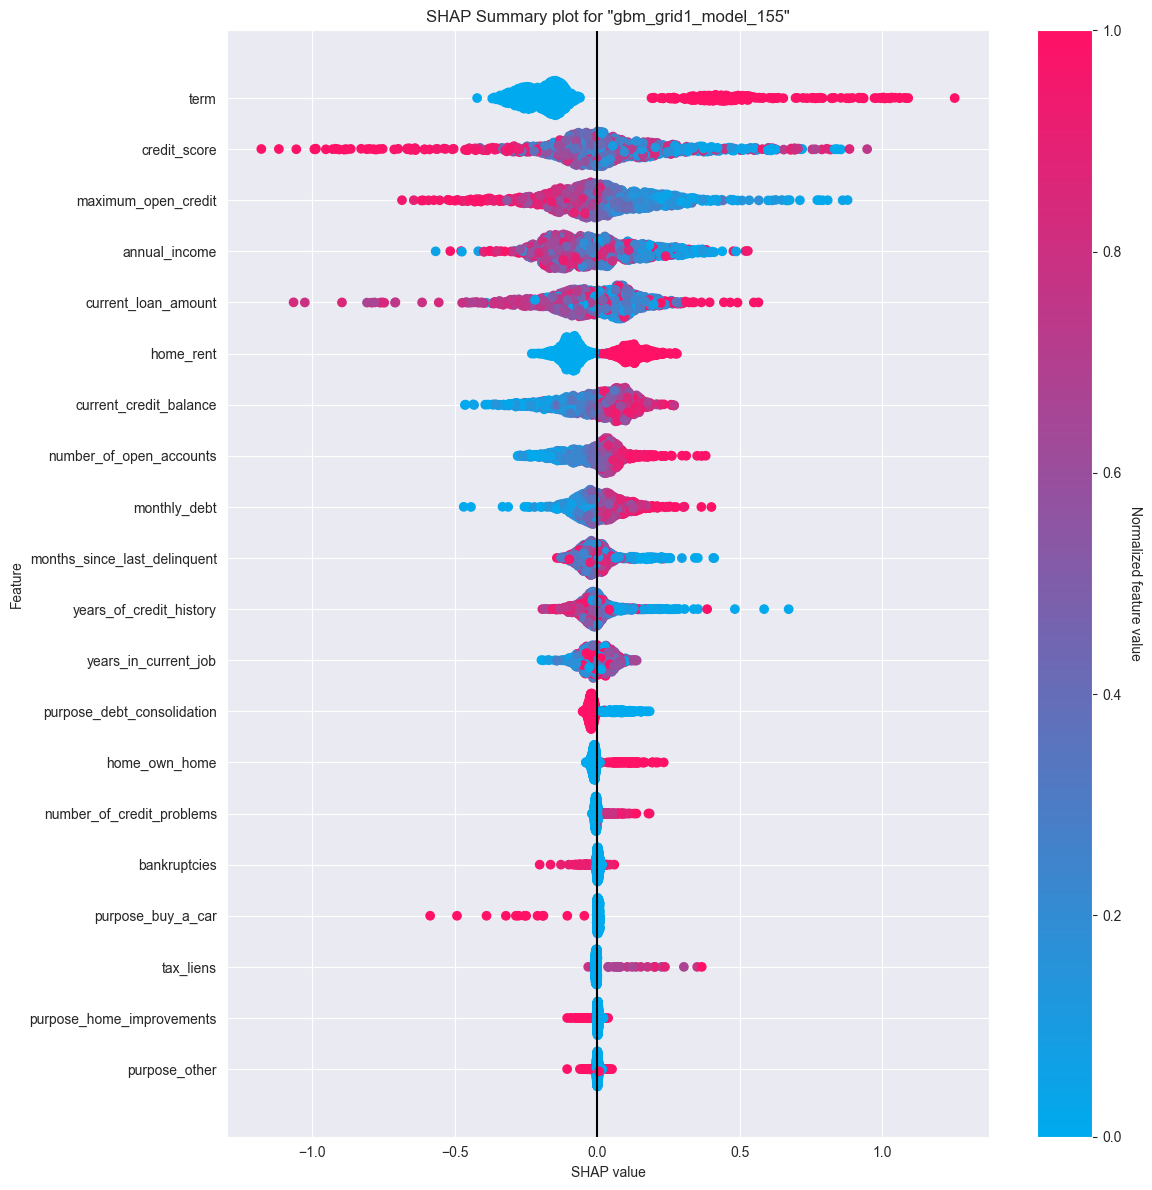

In [13]:
best_gbm1.shap_summary_plot(test)

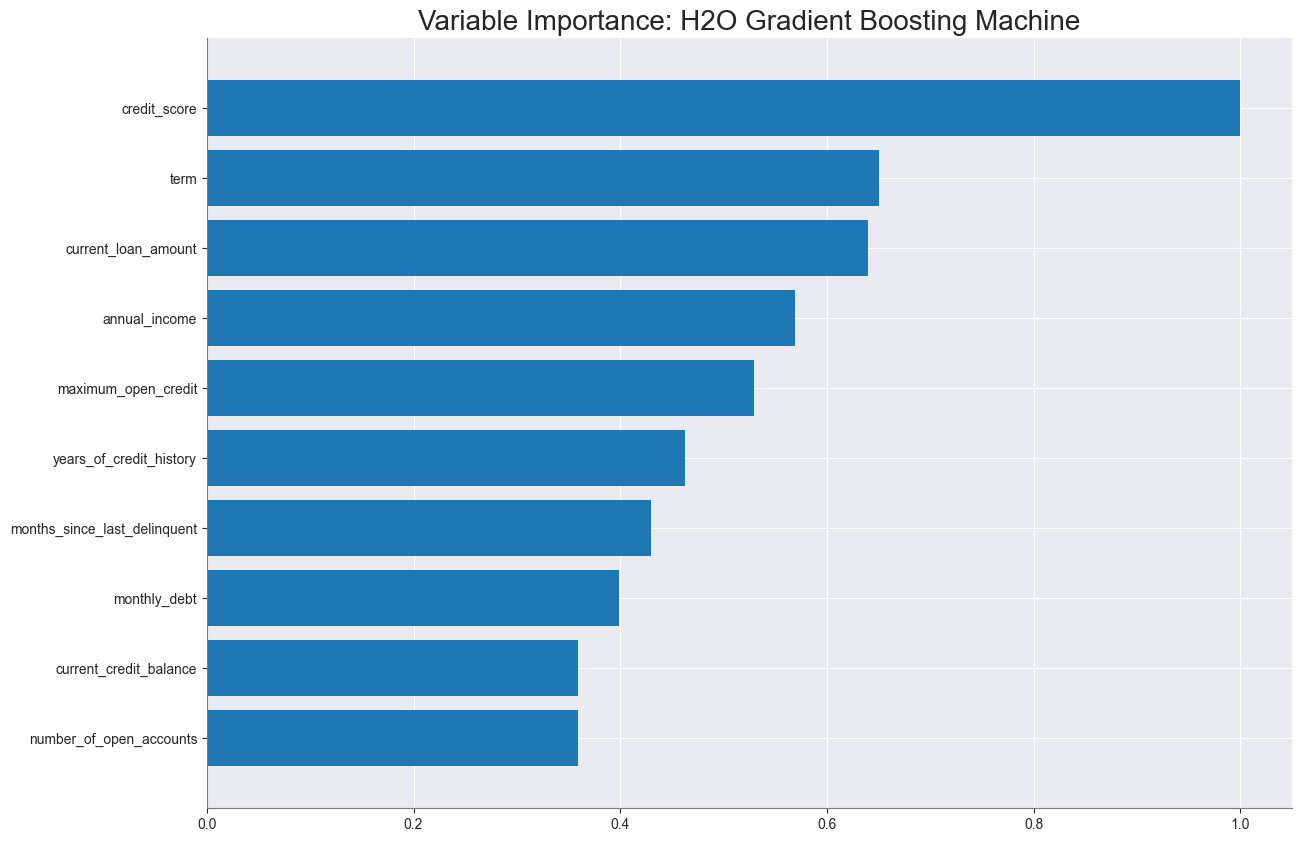

<Figure size 640x480 with 0 Axes>

In [14]:
best_gbm1.varimp_plot()

In [15]:
def calculate_metrics_summary(h2o_perf, df, model_name):
    #calculate precision, recall, and support for class 0 and 1
    precision_class_0 = h2o_perf.precision()[0][0]
    precision_class_1 = h2o_perf.precision()[0][1]
    recall_class_0 = h2o_perf.recall()[0][0]
    recall_class_1 = h2o_perf.recall()[0][1]
    support_class_0 = df.loan_status.value_counts()['loan_refused']
    support_class_1 = df.loan_status.value_counts()['loan_given']

    #calculate weighted precision and recall
    precision = (precision_class_0 * support_class_0 + precision_class_1 * support_class_1) / (support_class_0 + support_class_1)
    recall = (recall_class_0 * support_class_0 + recall_class_1 * support_class_1) / (support_class_0 + support_class_1)

    #calculate F1 score for class 0 and class 1
    f1_class_0 = 2 * (precision_class_0 * recall_class_0) / (precision_class_0 + recall_class_0)
    f1_class_1 = 2 * (precision_class_1 * recall_class_1) / (precision_class_1 + recall_class_1)

    f1 = (f1_class_0 * support_class_0 + f1_class_1 * support_class_1) / (support_class_0 + support_class_1)
    auc = h2o_perf.auc()

    print(f"The F1 score for {model_name} is {f1}")
    print(f"The precision score for {model_name} is {precision}")
    print(f"The recall score for {model_name} is {recall}")
    print(f"The AUC score for {model_name} is {auc}")

    return f1, precision, recall, auc

In [16]:
f1_gbm, precision_gbm, recall_gbm, auc_gbm = calculate_metrics_summary(gbm_perf, df_use, 'GBM')

The F1 score for GBM is 0.7378470472310934
The precision score for GBM is 0.9805154531679187
The recall score for GBM is 0.727800938088303
The AUC score for GBM is 0.6918409189624262


In [17]:
model_path = h2o.save_model(
    best_gbm1,
    path = "model",
    force = True,
    export_cross_validation_predictions = False
)
model_path

'D:\\LoanLens\\training\\model\\gbm_grid1_model_155'